In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense


In [2]:
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)
stock = '^NSEI'  # Replace with your desired stock symbol

data = yf.download(stock, start, end)
data.reset_index(inplace=True)
data.tail()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
4298,2025-03-28,23519.349609,23649.199219,23450.199219,23600.400391,295400
4299,2025-04-01,23165.699219,23565.150391,23136.400391,23341.099609,314300
4300,2025-04-02,23332.349609,23350.000000,23158.449219,23192.599609,341000
4301,2025-04-03,23250.099609,23306.500000,23145.800781,23150.300781,283200
4302,2025-04-04,22904.449219,23214.699219,22857.449219,23190.400391,466800


In [5]:
num_zero_rows = 600  # Change if needed
zero_rows = pd.DataFrame(np.nan, index=range(num_zero_rows), columns=data.columns)
data = pd.concat([data, zero_rows], ignore_index=True)
print(data.shape)


(4903, 6)


C:\Users\KIIT\AppData\Local\Temp\ipykernel_4532\2319993764.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, zero_rows], ignore_index=True)


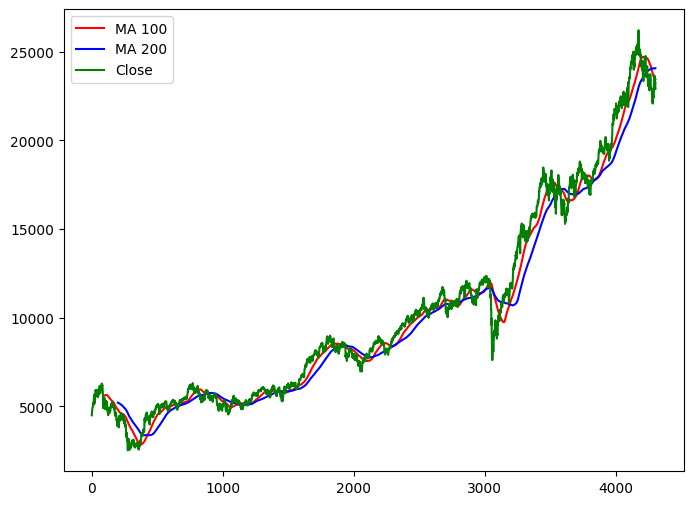

In [7]:
ma_100_days = data['Close'].rolling(100).mean()
ma_200_days = data['Close'].rolling(200).mean()

plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='MA 100')
plt.plot(ma_200_days, 'b', label='MA 200')
plt.plot(data['Close'], 'g', label='Close')
plt.legend()
plt.show()


In [9]:
def calculate_rsi(df, period=14, price_col='Close'):
    delta = df[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['RSI'] = calculate_rsi(df)


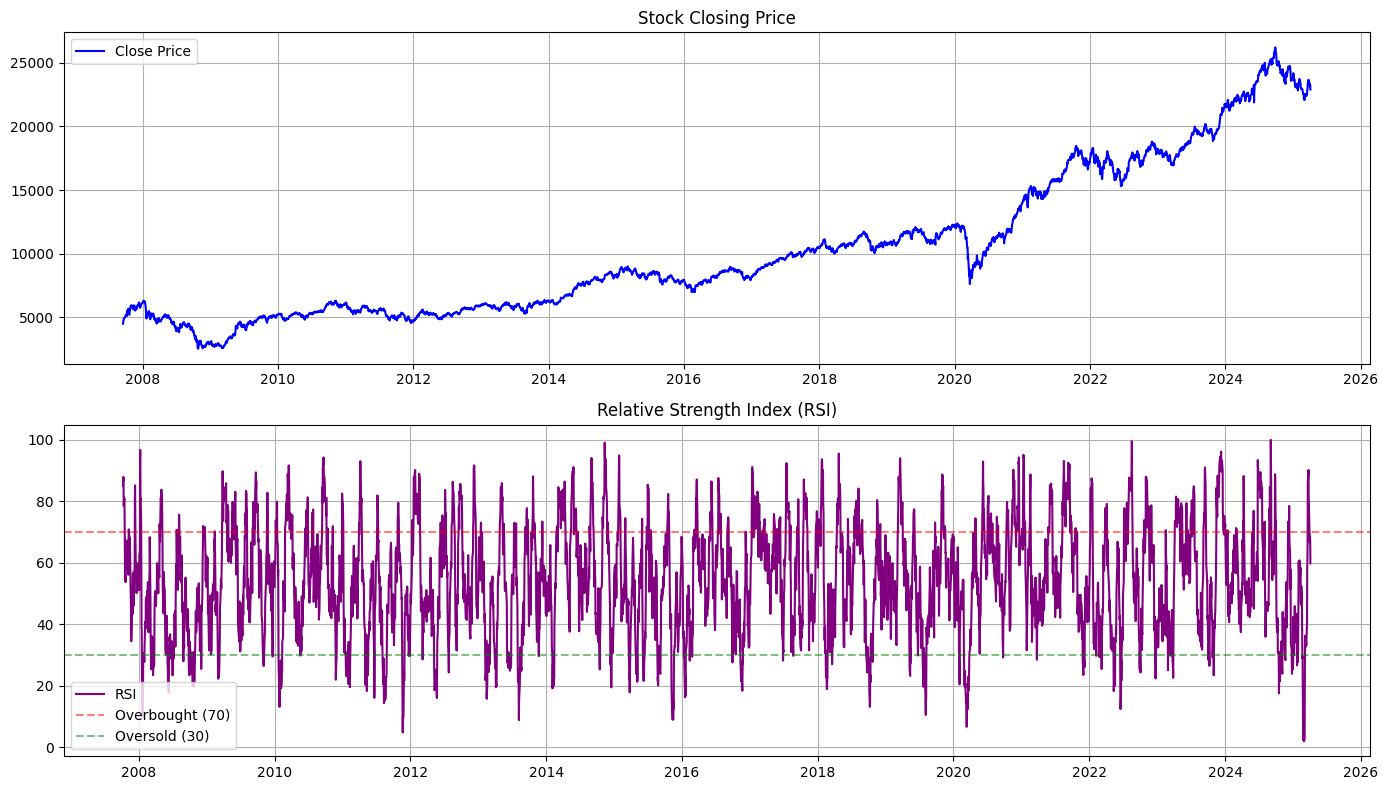

In [11]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Stock Closing Price')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
data.dropna(inplace=True)

data_train = pd.DataFrame(data['Close'][0: int(len(data) * 0.80)])
data_test = pd.DataFrame(data['Close'][int(len(data) * 0.80):])

print(data_train.shape[0])
print(data_test.shape[0])


3442
861


In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

x, y = np.array(x), np.array(y)


In [17]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=25, batch_size=32, verbose=1)


C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 337ms/step - loss: 0.0494
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 328ms/step - loss: 0.0047
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - loss: 0.0052
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 34s 324ms/step - loss: 0.0040
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 308ms/step - loss: 0.0035
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - loss: 0.0033
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - loss: 0.0030
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 308ms/step - loss: 0.0028
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 34s 324ms/step - loss: 0.0033
Epoch 10/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - loss: 0.0025
Epoch 11/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 298ms/step - loss: 0.0024
Epoch 12/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - loss: 0.0022
Epoch 13/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 285ms/step - loss: 0.0023
Epoch 14/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - loss: 0.0019
Epoch 15/25
105

In [18]:
past_100_days = data_train.tail(100)

In [19]:
data_test = pd.concat([past_100_days, data_test], ignore_index=True)

In [20]:
data_test_scale = scaler.transform(data_test)

In [21]:
x_test = []
y_test = []

for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i])
    y_test.append(data_test_scale[i, 0])

In [22]:

x_test, y_test = np.array(x_test), np.array(y_test)
y_pred = model.predict(x_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step


In [23]:
scale_factor = 1 / scaler.scale_
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

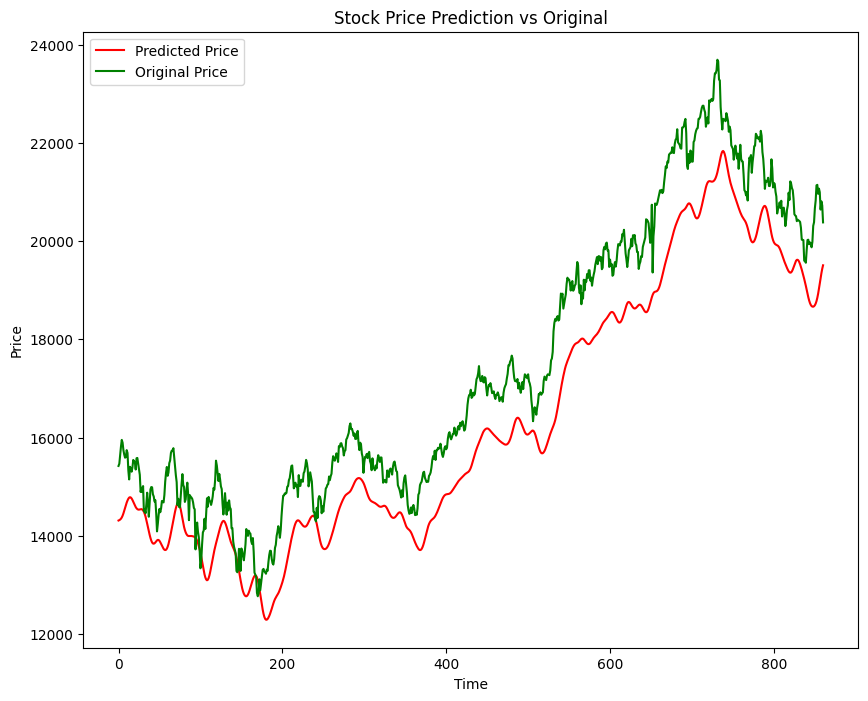

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(y_pred, 'r', label='Predicted Price')
plt.plot(y_test, 'g', label='Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title("Stock Price Prediction vs Original")
plt.legend()
plt.show()

In [25]:
future_days = 30  # Days to predict into the future

last_100_scaled = data_train_scale[-100:]
pred_input = list(last_100_scaled.reshape(100))
future_predicted = []

for _ in range(future_days):
    x_input = np.array(pred_input[-100:]).reshape(1, 100, 1)
    pred = model.predict(x_input, verbose=0)
    future_predicted.append(pred[0, 0])
    pred_input.append(pred[0, 0])

future_predicted = np.array(future_predicted).reshape(-1, 1)
future_predicted = future_predicted * scale_factor


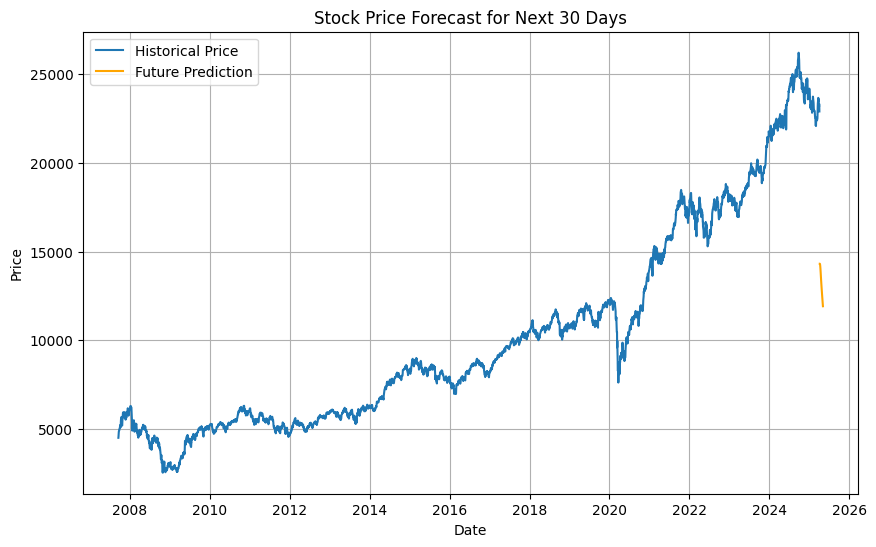

In [26]:
future_dates = pd.date_range(start=end + timedelta(days=1), periods=future_days)

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], label='Historical Price')
plt.plot(future_dates, future_predicted, label='Future Prediction', color='orange')
plt.title('Stock Price Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
model.save('Stock_Prediction_Future_Model2.keras')
